In [520]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import timedelta
import json
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.base import clone


In [521]:
def kombinere_df(file1_path, file2_path, kombineringspunkt):
    """
    Leser og slår sammen to JSON-filer, og returnerer et kombinert flat DataFrame.
    
    Argumenter:
    - file1_path: sti til første JSON-fil
    - file2_path: sti til andre JSON-fil
    - kombineringspunkt: kolonnenavn for å merge (f.eks. 'Dato')
    """
    #Les og normaliser første fil
    with open(file1_path, "r", encoding="utf-8") as f1:
        json1 = json.load(f1)
    df1 = pd.json_normalize(json1)

    #Les og normaliser andre fil
    with open(file2_path, "r", encoding="utf-8") as f2:
        json2 = json.load(f2)
    df2 = pd.json_normalize(json2)

    #Kombiner data
    df_combined = pd.merge(df1, df2, on=kombineringspunkt, how='inner')

    #Konverter til datetime
    df_combined[kombineringspunkt] = pd.to_datetime(df_combined[kombineringspunkt])


    return df_combined

data=kombinere_df("../data/analyzed_data/frostAPI_analyzed_data.json", 
             "../data/analyzed_data/niluAPI_analyzed_data.json", 'Dato')

print(data.head())

        Dato    Nedbør  Temperatur  Vindhastighet  Interpolert_Nedbør  \
0 2010-04-02  1.623594   -0.532196       0.202134               False   
1 2010-04-03  1.266981   -0.582540      -0.341967               False   
2 2010-04-04 -0.818619   -0.418925       0.836919               False   
3 2010-04-05 -0.818619   -0.142038      -0.251284               False   
4 2010-04-06 -0.818619   -0.507025      -1.067436               False   

   Interpolert_Temperatur  Interpolert_Vindhastighet  Dekningsgrad_NO2  \
0                   False                      False             100.0   
1                   False                      False             100.0   
2                   False                      False             100.0   
3                   False                      False             100.0   
4                   False                      False             100.0   

   Dekningsgrad_O3  Dekningsgrad_SO2  Verdi_NO2_Trans  Verdi_O3_Trans  \
0            100.0             100.0       

Her er alle funksjonen

## 📈 Visualisering: Modellprediksjon og fremtidige verdier

Denne grafen viser hvordan en regresjonsmodell har blitt brukt til å analysere og forutsi utviklingen i måledata for **`<target_col>`** (f.eks. NO₂, SO₂, O₃). Grafen er delt i tre hoveddeler:

---

### **Treningsdata** (rosa)
- Modellens treningsgrunnlag.
- Viser faktiske historiske verdier som modellen har blitt trent på.

---

### **Testdata** (rød og oransje)
- Rød linje: Faktiske verdier som modellen **ikke har sett under trening**.
- Oransje streket linje: Modellens prediksjon for testperioden.
- Dette sammenlignes for å evaluere modellens ytelse.

---

### **Fremtidig prediksjon** (blå)
- Modellens estimerte verdier frem i tid, basert på siste kjente datapunkt.
- Viser potensielt utviklingsforløp under forutsetning av stabile inputverdier.

---

### **Dekningsgrad** (bakgrunnsfarge)
- **Mørk grå**: Ingen måledata (dekningsgrad = 0.0), trolig interpolerte verdier.
- **Lys grønn**: Delvis datadekning (0 < dekningsgrad < 100), usikker kvalitet.

---

### ➖ **Vertikal strek**
- Marker overgangen fra historiske data til fremtidig prediksjon.

---

Grafen gir et komplett bilde av hvordan modellen presterer historisk og hvilke antagelser den gjør om fremtiden.


In [522]:
def legg_til_sesongvariabler(df, datokolonne="Dato"):
    """
    Legger til sesongbaserte variabler i datasettet basert på en datokolonne.

    Args:
        df (pd.DataFrame): Datasettet som inneholder en datokolonne.
        datokolonne (str, optional): Navnet på kolonnen som inneholder datoer. 
                                     Standard er "Dato".

    Returns:
        pd.DataFrame: En kopi av datasettet med ekstra kolonner:
            - "måned": Måned (1–12)
            - "ukedag": Ukedag (0=mandag, 6=søndag)
            - "dag_i_året": Dagnummer i året (1–365)
            - "sin_dag": Sinus av dag_i_året (for å modellere sesonger)
            - "cos_dag": Cosinus av dag_i_året (for å modellere sesonger)
    """
    df = df.copy()
    df[datokolonne] = pd.to_datetime(df[datokolonne])
    df["måned"] = df[datokolonne].dt.month
    df["ukedag"] = df[datokolonne].dt.weekday
    df["dag_i_året"] = df[datokolonne].dt.dayofyear
    df["sin_dag"] = np.sin(2 * np.pi * df["dag_i_året"] / 365)
    df["cos_dag"] = np.cos(2 * np.pi * df["dag_i_året"] / 365)
    return df


In [523]:
def tren_modell(df, target_col, features, modell_objekt):
    """
    Trener en prediksjonsmodell basert på utvalgte inputvariabler og målvariabel.

    Args:
        df (pd.DataFrame): Datasettet som inneholder input- og målvariabler.
        target_col (str): Navnet på kolonnen som skal brukes som målvariabel (y).
        features (list of str): Liste over kolonner som skal brukes som input (X).
        modell_objekt (obj): Et modellobjekt som implementerer .fit(X, y),
                             f.eks. LinearRegression(), LGBMRegressor().

    Returns:
        modell_objekt: Den trenede modellen, klar for prediksjon med .predict().
    """
    X = df[features]
    y = df[target_col]
    modell_objekt.fit(X, y)
    return modell_objekt

In [524]:

def prediker_fremtid(df_siste, model, features, target_col, antall_dager, datokolonne="Dato"):
    """
    Genererer fremtidige prediksjoner basert på siste kjente rad i datasettet.

    Args:
        df_siste (pd.DataFrame): Det historiske datasettet som modellen baseres på.
        model (obj): En trent modell med støtte for .predict().
        features (list of str): Liste over feature-kolonner som brukes til prediksjon.
        target_col (str): Navnet på kolonnen som skal predikeres.
        antall_dager (int): Hvor mange dager frem i tid det skal predikeres.
        datokolonne (str, optional): Navnet på datokolonnen. Standard er "Dato".

    Returns:
        pd.DataFrame: En DataFrame med kolonnene:
            - "Dato": Fremtidige datoer
            - "predicted_<target_col>": Modellens predikerte verdier for hver dag
    """
    siste_dato = pd.to_datetime(df_siste[datokolonne].max())
    siste_rad = df_siste.iloc[-1]

    fremtidige_datoer = [siste_dato + pd.Timedelta(days=i) for i in range(1, antall_dager + 1)]
    base_data = {"Dato": fremtidige_datoer}

    sesong_features = {"måned", "ukedag", "dag_i_året", "sin_dag", "cos_dag"}
    for f in features:
        if f not in sesong_features and f in siste_rad:
            base_data[f] = siste_rad[f]
    df_fremtid = pd.DataFrame(base_data)
    df_fremtid = legg_til_sesongvariabler(df_fremtid, datokolonne)        

    X_fremtid = df_fremtid[features]
    df_fremtid[f"predicted_{target_col}"] = model.predict(X_fremtid)

    return df_fremtid[["Dato", f"predicted_{target_col}"]]

In [525]:


def plot_prediksjon(y_train, y_test, y_pred, df_fremtid, target_col, dekningsgrad=None):
    """
    Visualiserer treningsdata, testdata (faktisk og predikert), og fremtidige prediksjoner.

    Args:
        y_train (pd.Series): Faktiske verdier som modellen ble trent på.
        y_test (pd.Series): Faktiske verdier brukt for testing av modellen.
        y_pred (array-like): Modellens prediksjoner på testsettet.
        df_fremtid (pd.DataFrame): DataFrame med fremtidige prediksjoner.
                                   Må inneholde kolonnen "predicted_<target_col>".
        target_col (str): Navnet på målvariabelen (target) som visualiseres.
        dekningsgrad (pd.Series, optional): Serie med dekningsgrad.
                                            Brukes til å markere interpolerte eller delvis manglende data.

    Returns:
        Viser matplotlib-plot.
    """
    #Fremtidig prediksjon
    forecast = df_fremtid[f"predicted_{target_col}"].values

    #Lag x-aksen (tidsindeks)
    total_len = len(y_train) + len(y_test) + len(forecast)
    train_x = range(0, len(y_train))
    test_x = range(len(y_train), len(y_train) + len(y_test))
    future_x = range(len(y_train) + len(y_test), total_len)

    plt.figure(figsize=(14, 6))

    #Marker områder med mindre enn full dekning
    if dekningsgrad is not None:
        dekningsgrad = dekningsgrad.reset_index(drop=True)
        for idx, val in enumerate(dekningsgrad):
            if val ==0.0:  #interpolisert
                plt.axvspan(idx - 0.5, idx + 0.5, color='darkgray', alpha=0.4)
            if 0.0 < val < 100.0:  #mindre enn full dekning
                plt.axvspan(idx - 0.5, idx + 0.5, color='lightgreen', alpha=0.4)

    #Treningsdata
    plt.plot(train_x, y_train.values, label="Treningsdata", color="#FF69B4")
    
    #Testdata
    plt.plot(test_x, y_test.values, label="Testdata (ekte)", color="red")
    plt.plot(test_x, y_pred, label="Testdata (modell)", color="orange", linestyle="--")

    #Fremtidig prediksjon
    plt.plot(future_x, forecast, label="Fremtidig prediksjon", color="blue")

    # Marker overgang
    plt.axvline(x=len(y_train) + len(y_test) - 1, color='gray', linestyle='--', alpha=0.6)

    #Plot detaljer
    plt.title(f"{target_col} – Historikk, test og fremtid", fontsize=16)
    plt.xlabel("Tidsindeks")
    plt.ylabel(target_col)
    plt.grid(True, alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


In [526]:

def prediksjon_med_fremtidige_verdier(df, target_col, features, model_objekt,
                                      antall_dager=365, test_size=0.2, dekningsgrad=None):
    """
    Trener og evaluerer en prediksjonsmodell, og bruker den til å forutsi fremtidige verdier.

    Args:
        df (pd.DataFrame): Datasettet som inneholder datokolonne, inputvariabler og target.
        target_col (str): Navn på målvariabelen (kolonnen som skal predikeres).
        features (list of str): Liste over kolonnenavn som brukes som input (X).
        model_objekt (obj): Et skalert/skalert modellobjekt med .fit() og .predict(), 
                            f.eks. LinearRegression(), LGBMRegressor(), Pipeline(...)
        antall_dager (int, optional): Hvor mange dager frem i tid det skal predikeres. Default er 365.
        test_size (float, optional): Andel av data som skal brukes som testsett. Default er 0.2.
        dekningsgrad (pd.Series, optional): En valgfri Series som markerer interpolerte/mangelfulle verdier 
                                            (brukes til fargelegging i plottet).

    Returns:
        Resultatet vises som evaluering i konsollen og som et plott med historikk, test og fremtid.
    """

    #Forbered data
    df = df.copy()
    df["Dato"] = pd.to_datetime(df["Dato"])
    df = legg_til_sesongvariabler(df)
    if isinstance(model_objekt, LGBMRegressor):
        model_objekt.set_params(verbose=-1)


    X = df[features]
    y = df[target_col]

    #Del opp i trenings- og testdata (behold rekkefølge)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    #Tren på treningsdata
    model = model_objekt.fit(X_train, y_train)

    #Evaluer på testdata
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f"\n🔍 Evaluering av modellen '{model_objekt.__class__.__name__}'for '{target_col}' (på testdata):")
    print(f"- R²-score: {r2:.4f}")
    print(f"- MSE: {mse:.4f}")

    #Tren ny modell på hele datasettet for fremtidsprediksjon
    model_full = clone(model_objekt) # kopi med samme innstillinger
    model_full = tren_modell(df, target_col, features, model_full)

    #Prediker fremtid
    df_fremtid = prediker_fremtid(df, model_full, features, target_col, antall_dager)

    #Visualiser historikk + fremtid
    plot_prediksjon(y_train, y_test, y_pred, df_fremtid, target_col, dekningsgrad)




🔍 Evaluering av modellen 'LGBMRegressor'for 'Verdi_NO2_Trans' (på testdata):
- R²-score: 0.6035
- MSE: 0.4715


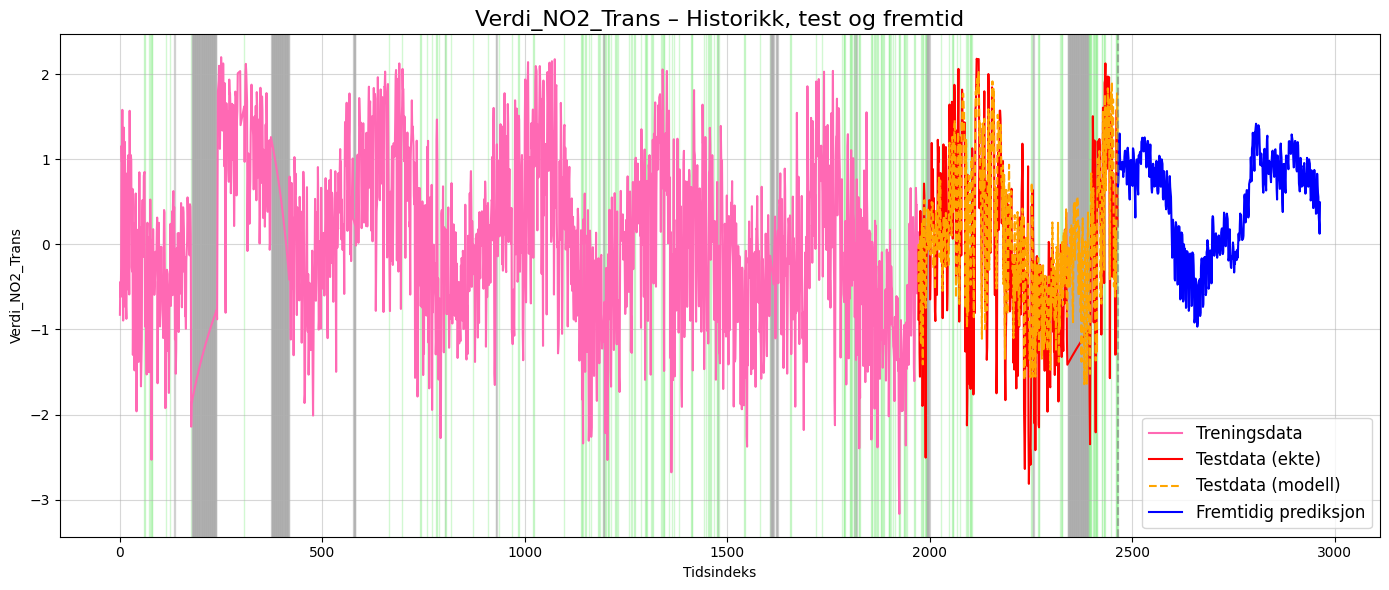


🔍 Evaluering av modellen 'LinearRegression'for 'Verdi_NO2_Trans' (på testdata):
- R²-score: 0.5821
- MSE: 0.4970


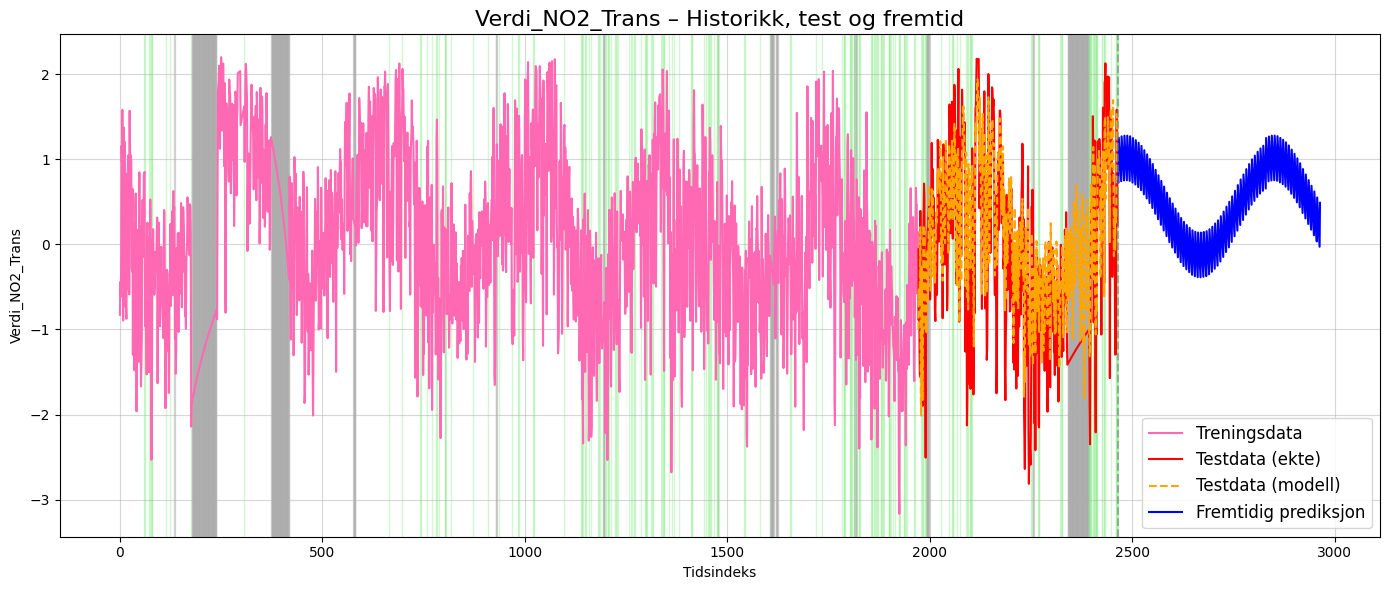

In [527]:

features = ["Nedbør", "Temperatur", "Vindhastighet", "måned", "ukedag", "sin_dag", "cos_dag"]

prediksjon_med_fremtidige_verdier(df=data, target_col="Verdi_NO2_Trans", features=features, model_objekt=LGBMRegressor(), 
                                  antall_dager=500, dekningsgrad=data["Dekningsgrad_NO2"])         
prediksjon_med_fremtidige_verdier(df=data, target_col="Verdi_NO2_Trans", features=features, model_objekt=LinearRegression(), 
                                  antall_dager=500, dekningsgrad=data["Dekningsgrad_NO2"])




🔍 Evaluering av modellen 'LGBMRegressor'for 'Verdi_SO2_Trans' (på testdata):
- R²-score: -0.7999
- MSE: 0.7299


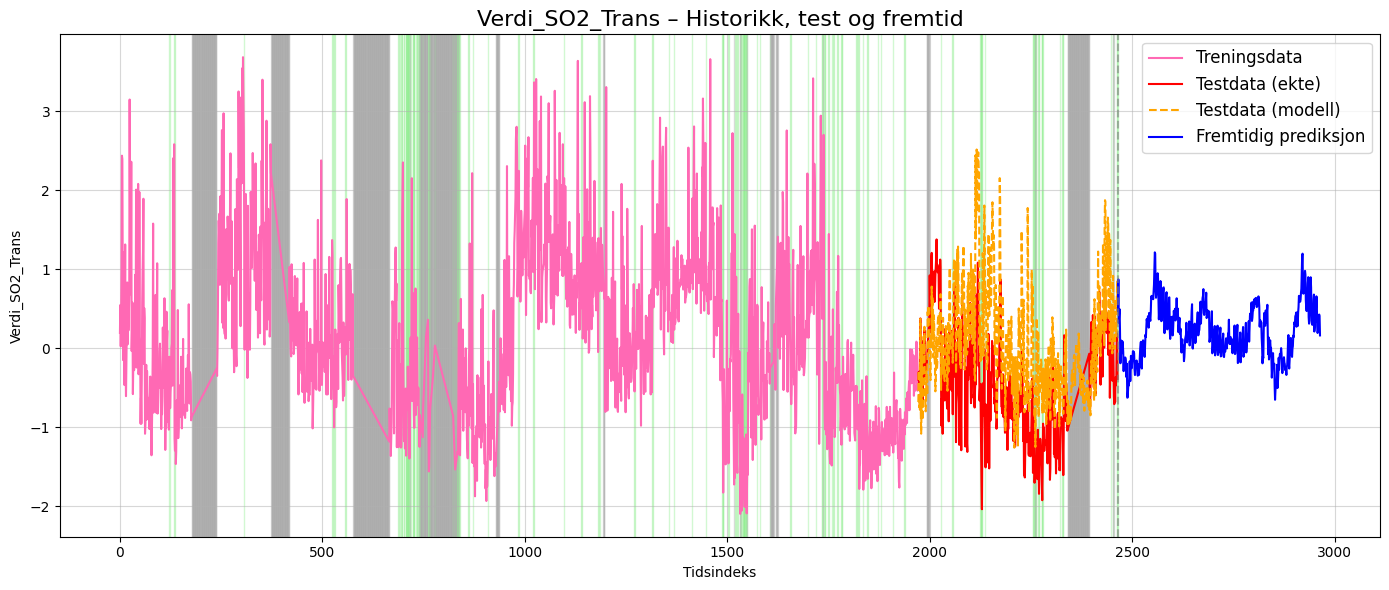


🔍 Evaluering av modellen 'LinearRegression'for 'Verdi_SO2_Trans' (på testdata):
- R²-score: -0.4833
- MSE: 0.6015


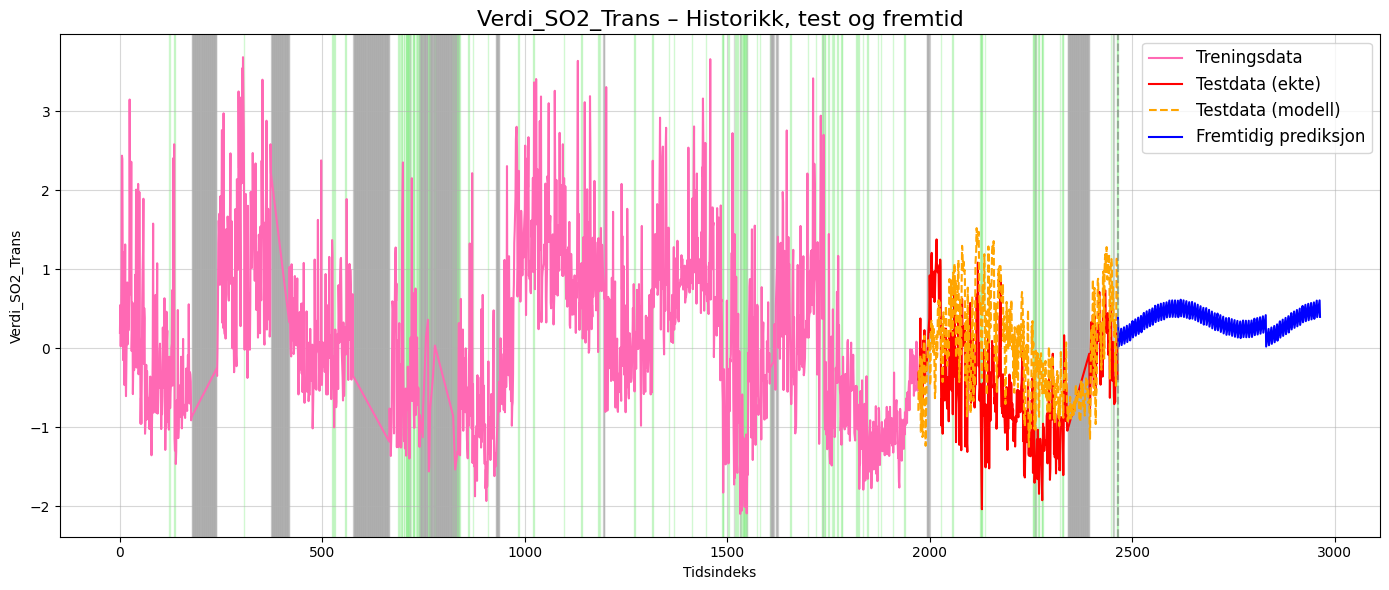

In [528]:
features = ["Nedbør", "Temperatur", "Vindhastighet", "Verdi_NO2_Trans", "måned", "ukedag", "sin_dag", "cos_dag"]

prediksjon_med_fremtidige_verdier(df=data, target_col="Verdi_SO2_Trans", features=features, model_objekt=LGBMRegressor(), 
                                  antall_dager=500, dekningsgrad=data["Dekningsgrad_SO2"])
prediksjon_med_fremtidige_verdier(df=data, target_col="Verdi_SO2_Trans", features=features, model_objekt=LinearRegression(), 
                                  antall_dager=500, dekningsgrad=data["Dekningsgrad_SO2"])





🔍 Evaluering av modellen 'LGBMRegressor'for 'Verdi_O3_Trans' (på testdata):
- R²-score: -0.3072
- MSE: 1.1242


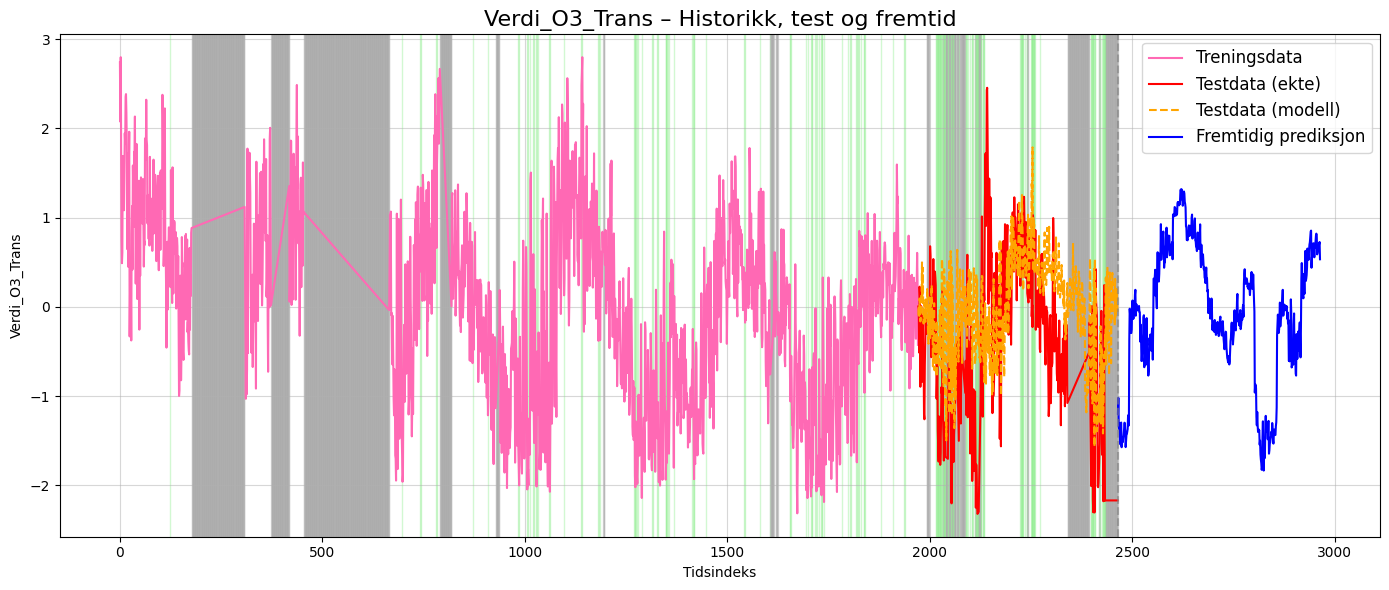


🔍 Evaluering av modellen 'LinearRegression'for 'Verdi_O3_Trans' (på testdata):
- R²-score: -0.0643
- MSE: 0.9153


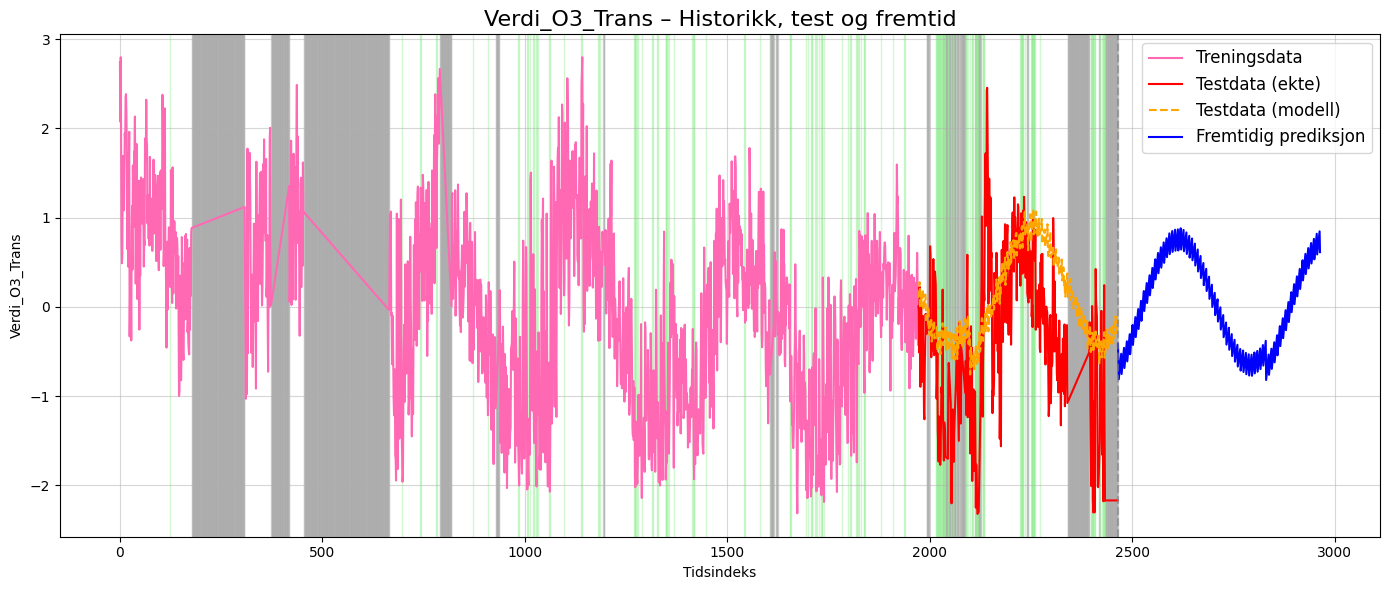

In [529]:

features = ["Nedbør", "Verdi_SO2_Trans" ,"måned", "ukedag", "sin_dag", "cos_dag"]

prediksjon_med_fremtidige_verdier(df=data, target_col="Verdi_O3_Trans", features=features, model_objekt=LGBMRegressor(), 
                                  antall_dager=500, dekningsgrad=data["Dekningsgrad_O3"])
prediksjon_med_fremtidige_verdier(df=data, target_col="Verdi_O3_Trans", features=features, model_objekt=LinearRegression(), 
                                  antall_dager=500, dekningsgrad=data["Dekningsgrad_O3"])


In [530]:


def vis_koeffisienter_linærmodell(df, features, target_cols, datokolonne="Dato"):
    """
    Viser koeffisienter fra lineær regresjon for hver target-kolonne.

    Args:
        df (pd.DataFrame): Datasettet.
        features (list of str): Liste over inputvariabler.
        target_cols (list of str): Liste over målvariabler som skal evalueres.
        datokolonne (str): Navn på datokolonnen for sesongfeature-generering.
    """
    df = legg_til_sesongvariabler(df, datokolonne)

    for target in target_cols:
        f_clean = [f for f in features if f != target]

        model = tren_modell(df, target, f_clean, LinearRegression())

        # Hent og vis koeffisienter
        coeffs = pd.Series(model.coef_, index=f_clean)

        coeffs.plot(kind="bar", title=f"Koeffisienter for {target}", color="skyblue")
        plt.ylabel("Koeffisient")
        plt.tight_layout()
        plt.show()





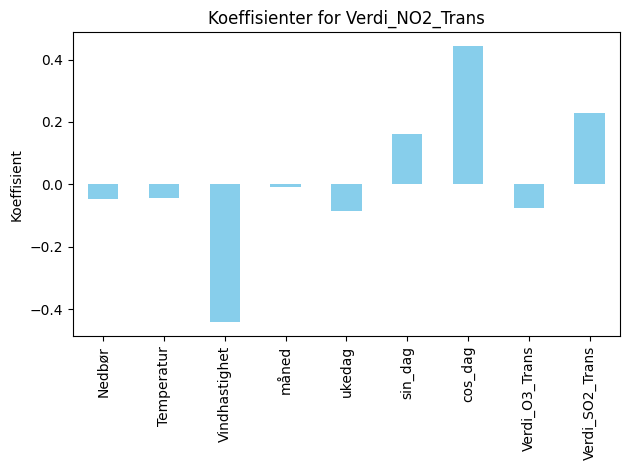

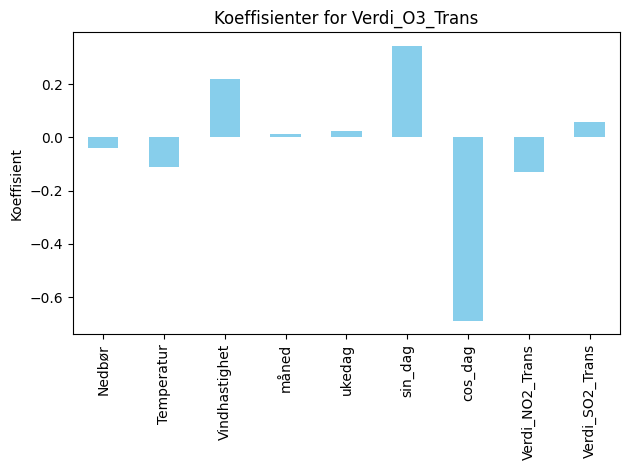

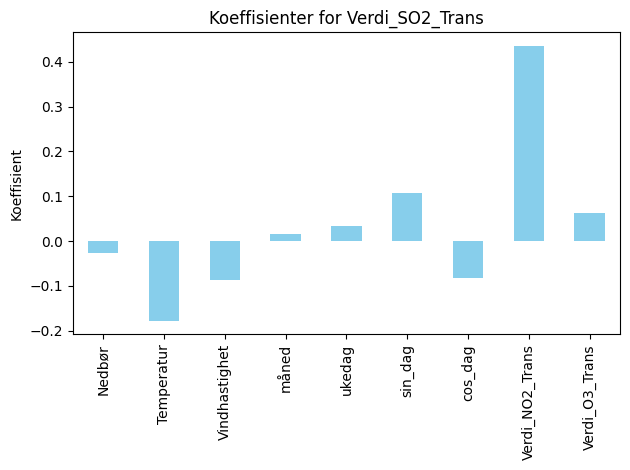

In [531]:
features = ["Nedbør", "Temperatur", "Vindhastighet", "måned", "ukedag", "sin_dag", 
            "cos_dag","Verdi_NO2_Trans", "Verdi_O3_Trans", "Verdi_SO2_Trans"]
vis_koeffisienter_linærmodell(data, features, ["Verdi_NO2_Trans", "Verdi_O3_Trans", "Verdi_SO2_Trans"])

### 📊 *Kort oppsummering av modellkoeffisienter*

---

#### Verdi_NO2_Trans (Nitrogendioksid)
- **↑** Øker tydelig om vinteren 
- **↑** Samvarierer med SO₂ 
- **↓** Reduseres av høy vindhastighet
- Svake effekter fra temperatur, O₃, nedbør og ukedager  

---

#### Verdi_O3_Trans (Ozon) 
- **↑** Øker tydelig på våren/sommeren 
- Sterkt sesongavhengig – lite påvirket av andre variabler  

---

#### Verdi_SO2_Trans (Svoveldioksid)
- **↑** Samvarierer sterkt med NO₂ 
- **↑** Øker med `sin_dag` (sesong), svakt med O₃ og ukedag  
- **↓** Reduseres av temperatur, vind og vinter 

---

#### cos_dag generelt:
- Positiv for NO₂ → mer NO₂ om vinteren  
- Negativ for SO₂ og O → disse reduseres vinterstid  



In [532]:
def plot_polynomregresjon(X, y, grader, feature, target_col):
    """
    Lager et scatterplot og polynomkurver for gitt X og y.

    Args:
        X (np.ndarray): Inputvariabel (1D array).
        y (np.ndarray): Målvariabel.
        grader (list): Grader av polynomer som skal tegnes.
        feature (str): Navn på feature (for labels).
        target_col (str): Navn på target (for labels).
    """
    x_range = np.linspace(X.min(), X.max(), 300)

    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, s=10, color="lightgray", label="Faktiske data")

    for deg in grader:
        model = np.poly1d(np.polyfit(X, y, deg))
        y_pred = model(X)
        r2 = r2_score(y, y_pred)
        plt.plot(x_range, model(x_range), label=f"{deg}. grad (R²={r2:.3f})")
    

    plt.xlabel(feature)
    plt.ylabel(target_col)
    plt.title(f"Polynomregresjon: {feature} → {target_col}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



    


In [533]:
def vis_polynomregresjon_for_feature(df, feature, target_col, grader=[1, 2, 3], datokolonne="Dato"):
    """
    Viser polynomregresjon mellom én feature og target med ulike grader.

    Args:
        df (pd.DataFrame): Datasettet.
        feature (str): Navnet på inputvariabelen (X).
        target_col (str): Navnet på målvariabelen (y).
        grader (list): Liste over grader som skal vises (default: [1, 2, 3]).
        datokolonne (str): Dato-kolonnen som brukes i sesongtransformasjon.
    """
    df = df.copy()
    df = legg_til_sesongvariabler(df, datokolonne)
    X = df[feature].values
    y = df[target_col].values

    plot_polynomregresjon(X, y, grader, feature, target_col)


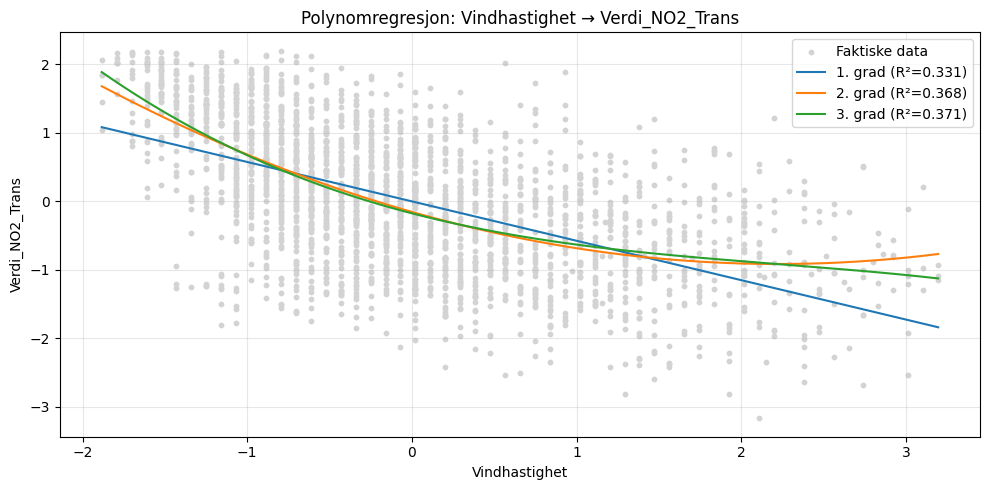

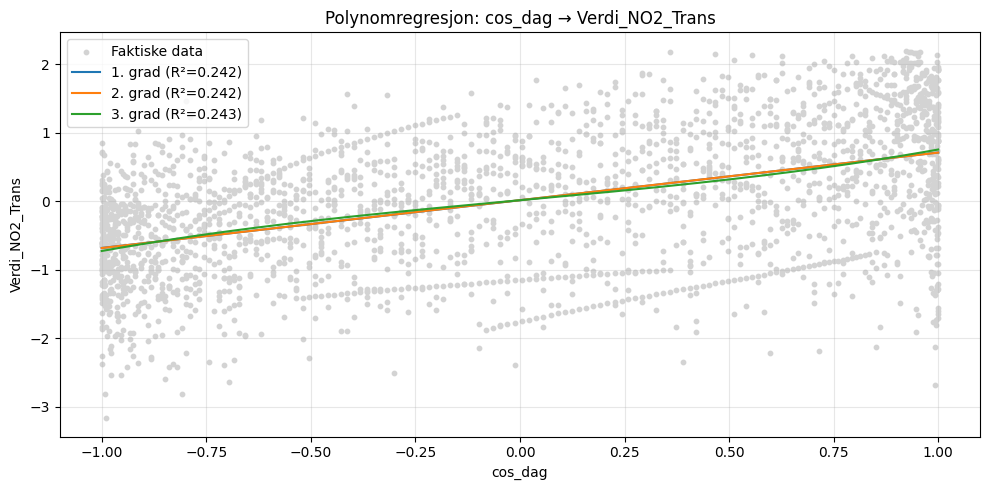

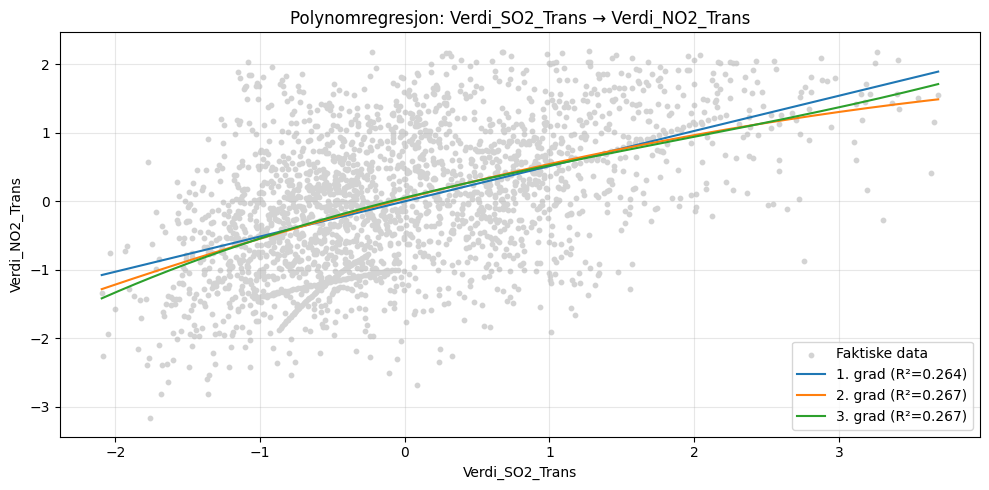

In [ ]:
vis_polynomregresjon_for_feature(df=data,feature="Vindhastighet", target_col="Verdi_NO2_Trans")
vis_polynomregresjon_for_feature(df=data,feature="cos_dag", target_col="Verdi_NO2_Trans")
vis_polynomregresjon_for_feature(df=data,feature="Verdi_SO2_Trans", target_col="Verdi_NO2_Trans")

### NO₂ – polynomregresjon
Basert på tidligere analyser er Vindhastighet, cos_dag og SO₂ valgt som forklaringsvariabler for NO₂.

##### Vindhastighet → NO₂
Sterk negativ sammenheng.
R² øker fra 0.33 til 0.37 når man bruker høyere grads polynom.
Dette tyder på at forholdet er delvis ikke-lineært, men negativt totalt sett.

##### cos_dag → NO₂
Tydelig positiv sammenheng.
R² holder seg rundt 0.24 for alle grader → i hovedsak lineært forhold.
Støtter at NO₂ øker vinterstid.

##### SO₂ → NO₂
Klar positiv sammenheng.
R² ~0.26 for alle grader, med liten gevinst av mer komplekse modeller.
Indikerer at sammenhengen er stabil og lineær.

##### Konklusjon:
Vindhastighet har sterk negativ effekt, og kan forklares bedre med et ikke-lineært uttrykk.
cos_dag og SO₂ har lineær og positiv påvirkning, og gir god forklaring på variasjonen i NO₂.
NO₂ ser dermed ut til å øke vinterstid (cos_dag) og med høyere SO₂, men falle ved økt vind.

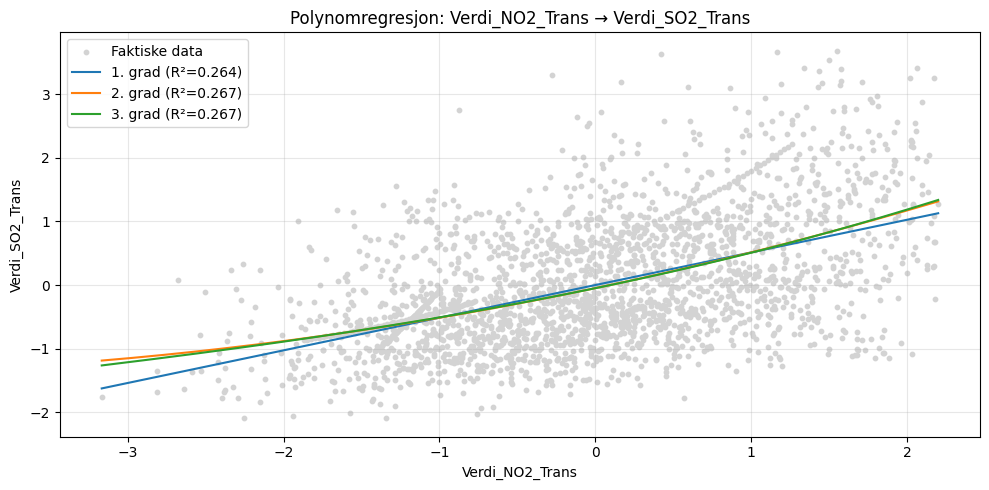

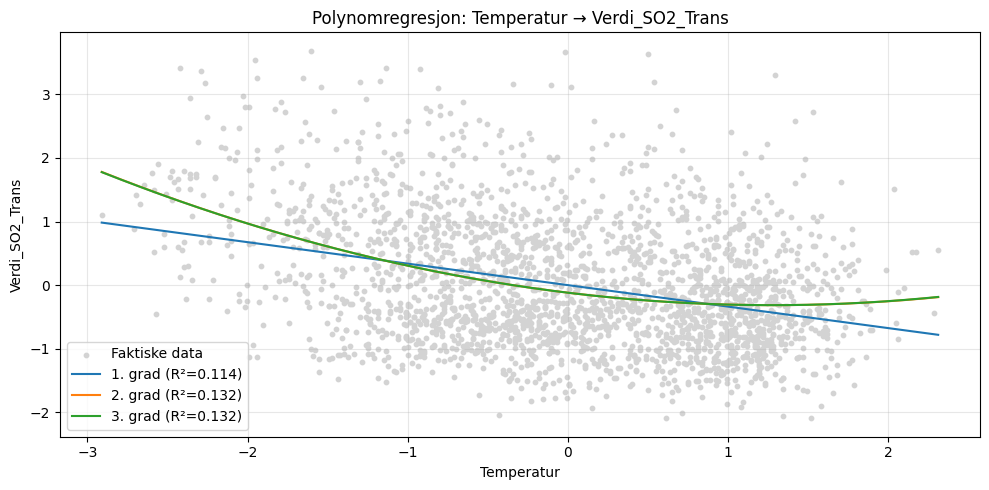

In [535]:
vis_polynomregresjon_for_feature(df=data,feature="Verdi_NO2_Trans", target_col="Verdi_SO2_Trans")
vis_polynomregresjon_for_feature(df=data,feature="Temperatur", target_col="Verdi_SO2_Trans")


### SO₂ – polynomregresjon

Basert på tidligere analyser er NO₂ og Temperatur valgt som sentrale forklaringsvariabler.

##### NO₂ → SO₂
Klar positiv og lineær sammenheng.
R² ligger stabilt rundt 0.26–0.27 for alle polynomgrader.
Lite forbedring ved høyere grad → forholdet er i hovedsak lineært.
##### Temperatur → SO₂
Svak negativ og noe ikke-lineær sammenheng.
R² forbedres noe (fra 0.11 til 0.13) ved å øke graden.
Tyder på en svak kurveformet effekt, men lav forklaringskraft totalt sett.

##### Konklusjon:

SO₂ påvirkes mest av NO₂, i et nær lineært forhold.
Temperatur gir svak prediksjon, og effekten er delvis ikke-lineær.

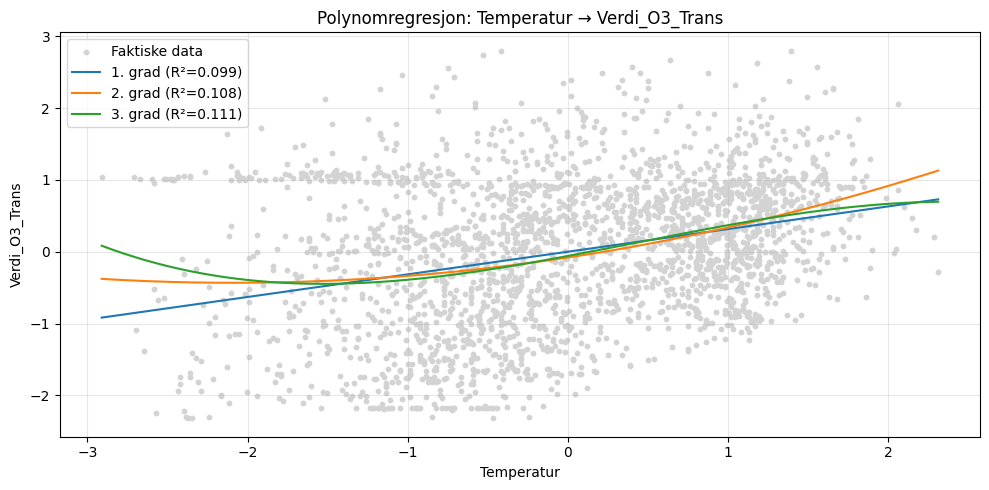

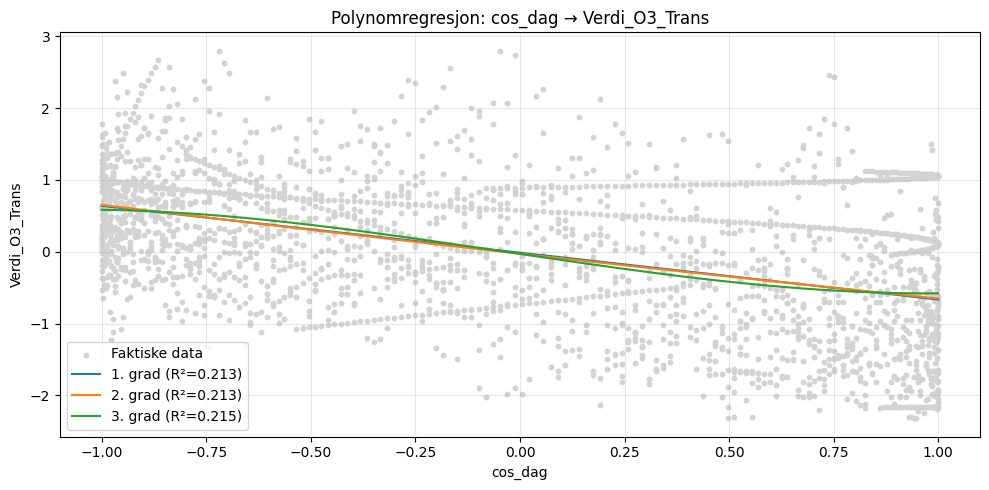

In [536]:
vis_polynomregresjon_for_feature(df=data,feature="Temperatur", target_col="Verdi_O3_Trans")
vis_polynomregresjon_for_feature(df=data,feature="cos_dag", target_col="Verdi_O3_Trans")


### O₃ – polynomregresjon
Basert på tidligere analyser ble Temperatur og cos_dag valgt som forklaringsvariabler for O₃.

##### Temperatur → O₃
Viser svak positiv sammenheng.
R² øker noe med høyere grad (fra 0.099 til 0.111), som antyder en svak ikke-lineær effekt, men med begrenset forklaringsevne totalt sett.

##### cos_dag → O₃
Tydelig negativ sammenheng.
R² forbedres svakt med økende grad, men ligger stabilt rundt 0.21.
Indikerer en stabil og delvis ikke-lineær effekt gjennom året.

##### Konklusjon:
cos_dag er best egnet for å modellere sesongvariasjoner i ozon.
Temperatur har en viss effekt, men gir lav forklaringskraft.
Dette styrker antakelsen om lavere ozonverdier vinterstid, hovedsakelig fanget opp av cos_dag.